Improving CO₂ Sequestration Through Machine Learning-Driven Prediction of Wettability in Tight Reservoirs
Elieneza Nicodemus Abelly a, Feng Yang a,*, Edwin Ernest Nyakillab, c, Fravian Mwinzarubi Marobo a, Christopher Nyangi Mkono a, Omari Athumani Mbuji a, Erasto E. Kasalaa, Allou Koffi Franck Kouassia

a Key Laboratory of Tectonics and Petroleum Resources (China University of Geosciences), Ministry of Education, Wuhan 430074, China
b Peking University Ordos Energy Research Institute, Huineng Kechuang Building, Minzu     Road, Kangbashi District, Ordos City, Inner Mongolia Autonomous Region 017010, China
c State Key Laboratory of Geomechanics and Geotechnical Engineering, Institute of Rock and Soil Mechanics, Chinese Academy of Sciences, Wuhan 430071, China


In [1]:
# intotroduction to python code

import pandas as pd
import numpy as np
data=pd.read_csv(r"D:\\abelly\\revision\\data co2.csv")
data

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,1,2.99,298.0,0.0,1,3,36.93
1,1,3.98,298.0,0.0,1,3,34.18
2,1,5.01,298.0,0.0,1,3,32.80
3,1,5.99,298.0,0.0,1,3,34.94
4,1,6.98,298.0,0.0,1,3,31.88
...,...,...,...,...,...,...,...
625,4,5.00,343.0,0.0,3,0,25.70
626,4,6.98,343.0,0.0,3,0,35.44
627,4,9.99,343.0,0.0,3,0,41.55
628,4,14.98,343.0,0.0,3,0,59.22


In [2]:
data.shape

(630, 7)

In [6]:
#Import librairy

import keras
#from keras.utils import np_utils
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import seaborn as sns
from numpy.core.fromnumeric import shape
from skimage.morphology import reconstruction
from sklearn.preprocessing import QuantileTransformer
#from keras.utils import np_utils


import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import pandas as pd
import time
import seaborn as sns

init_notebook_mode(connected=True)
%matplotlib inline

C:\Users\User\AppData\Local\Temp\ipykernel_28508\4181487539.py:12: DeprecationWarning:

numpy.core.fromnumeric is deprecated and has been renamed to numpy._core.fromnumeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.fromnumeric.shape.



# Tune parameters PSO

In [8]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pyswarms as ps
from sklearn.model_selection import cross_val_score,ShuffleSplit
from sklearn.metrics import mean_squared_error,r2_score
import joblib
import pandas as pd
import time
import matplotlib.pyplot as plt

In [9]:
def discretize(x,num):
    result = min(num-1, max(0, x))
    return int(result)    
    
def ErrorDistribs(y_true,y_pred):
    return abs(y_true-y_pred)/y_true    

In [28]:
class model():
    def __init__(self,n_particles=50,c1=0.5,c2=0.5,w=0.9,verbose=1,cv=5,scoring='neg_mean_squared_error'):
        self.StandardScaler=StandardScaler()
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.n_particles=n_particles
        self.c1=c1
        self.c2=c2
        self.w=w
        self.options={'c1':self.c1,'c2':self.c2,'w':self.w}
        self.verbose=verbose
        self.cv=cv
        self.scoring=scoring
        
    def train(self,X_train,y_train,reg,param_distribs):
        
        start=time.perf_counter()
        
        #self.X_train_pre=self.StandardScaler.fit_transform(X_train)
        self.X_train_pre=X_train #self.scaler.fit_transform(X_train)
        self.y_train=y_train#self.scaler.fit_transform(y_train)
        self.reg=reg
        self.param_distribs=param_distribs
        self.dimensions=len(param_distribs)
        
        upper=np.zeros(self.dimensions)
        lower=np.zeros(self.dimensions)
        
        for count, (key, value) in enumerate(self.param_distribs.items()):
            lower[count]=value[1]
            upper[count]=value[2]
        
        bounds=(lower,upper)

        optimizer=ps.single.GlobalBestPSO(n_particles=self.n_particles,dimensions=self.dimensions,options=self.options,bounds=bounds)
        best_cost,best_pos=optimizer.optimize(self.search,iters=100,verbose=self.verbose)       

#        best_pos=[-0.7811003950341757, 4.736212131795903, 0.3134303131418766]
        self.best_params={}
        
        for count, (key, value) in enumerate(self.param_distribs.items()):
            if value[0].__name__=='choice':
                index=value[0](best_pos[count])
                self.best_params[key]=value[3][index]                    
            else:
                self.best_params[key]=value[0](best_pos[count])

        self.final_model=self.reg(**self.best_params)
        self.final_model.fit(self.X_train_pre,self.y_train)
        y_pred=self.final_model.predict(self.X_train_pre)
        print('model',self.final_model)
        print('parameters',self.best_params)
        
        now=time.perf_counter()
        
        RMSE=np.sqrt(mean_squared_error(y_train,y_pred))/10**6
        R2=r2_score(y_train,y_pred)
        rela_error=ErrorDistribs(y_train,y_pred)*100
        #error_hist,_=np.histogram(rela_error,bins=50)
        error_median=np.median(rela_error)

        ""
        with open('D:\\abelly\\revision\\model\\{}.txt'.format(self.reg.__name__),'w+') as f:
            f.write('RMSE: {}\r\nR2: {}\r\nError_median: {}\r\n'.format(RMSE,R2,error_median))
        
        self.my_dict={}
        self.my_dict['train_time']=now-start
        self.my_dict['RMSE']=RMSE
        self.my_dict['R2']=R2
        self.my_dict['Error_Median']=error_median
        #self.my_dict['Error_Hist']=error_hist.ravel()
        self.my_dict['y_true']=self.y_train.ravel()
        self.my_dict['y_pred']=y_pred.ravel()
        

        joblib.dump(self.final_model,'D:\\abelly\\revision\\model\\{}.pkl'.format(self.reg.__name__))
    
#        my_model_loaded=joblib.load('{}.pkl'.format(self.reg.__name__))

    def search(self,param):
        score_array=np.zeros((self.n_particles,self.cv))
        fit_params={}
        
        for i in range(self.n_particles):

            for count, (key, value) in enumerate(self.param_distribs.items()):
                if value[0].__name__=='choice':
                    index=value[0](param[i,count])
                    fit_params[key]=value[3][index]                    
                else:
                    fit_params[key]=value[0](param[i,count])
            cv=ShuffleSplit(n_splits=5,test_size=0.3)
             #cv=self.cv
            score_array[i,:]=cross_val_score(self.reg(**fit_params),self.X_train_pre,self.y_train,scoring=self.scoring,cv=cv)
        return -np.mean(score_array,axis=1)
            
    def predict(self,X_test):
        """
        x: numpy.ndarray of shape (n_particles, dimensions)  
        """
        
        X_test_pre=X_test#self.StandardScaler.transform(X_test)
        y_pred=self.final_model.predict(X_test_pre)
        return y_pred
    
    def optimize(self):
        
        start=time.perf_counter()
        
        upper=250*np.ones(6)
        lower=15*np.ones(6)
        bounds=(lower,upper)
        
        optimizer=ps.single.GlobalBestPSO(n_particles=self.n_particles,dimensions=6,options=self.options,bounds=bounds)
        best_cost,best_pos=optimizer.optimize(self.predict,iters=100,verbose=self.verbose)
        best_pos=np.array(best_pos)
        
        cost_history=np.array(optimizer.cost_history)
        now=time.perf_counter()
        
        self.my_dict['opt_time']=now-start
        self.my_dict['X_test']=best_pos.ravel()
        self.my_dict['cost_history']=cost_history.ravel()
        
        df=pd.DataFrame(dict([(k,pd.Series(v)) for k,v in self.my_dict.items()]))
        df.to_excel('D:\\abelly\\revision\\model\\{}.xlsx'.format(self.reg.__name__))

In [29]:
def choice(x):
    return int(x)

def uniform(x):
    return x

def loguniform(x):
    return 10**x

In [30]:
#should be edited to the present working directory of the user
PWD = r"D:\\abelly\\revision\\"
data1 = pd.read_csv(PWD + "data co2.csv")
#REMOVE NAN data
data1=data1.dropna()
data1

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,1,2.99,298.0,0.0,1,3,36.93
1,1,3.98,298.0,0.0,1,3,34.18
2,1,5.01,298.0,0.0,1,3,32.80
3,1,5.99,298.0,0.0,1,3,34.94
4,1,6.98,298.0,0.0,1,3,31.88
...,...,...,...,...,...,...,...
625,4,5.00,343.0,0.0,3,0,25.70
626,4,6.98,343.0,0.0,3,0,35.44
627,4,9.99,343.0,0.0,3,0,41.55
628,4,14.98,343.0,0.0,3,0,59.22


In [13]:
datades=data1.describe()
datades.to_csv('D:\\abelly\\revision\\dataset\\CO2_rfdata_summary.csv')
datades

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
count,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,1.903175,9.584159,320.507776,1.271245,1.960317,1.734921,36.826825
std,1.251450,6.372300,17.725400,2.325763,0.895145,1.196665,19.743516
min,1.000000,0.040000,296.000000,0.000000,1.000000,0.000000,6.840000
25%,1.000000,5.000000,308.000000,0.000000,1.000000,1.000000,22.130000
50%,1.000000,9.020000,318.000000,0.200000,2.000000,2.000000,32.540000
75%,3.000000,12.010000,323.000000,1.000000,3.000000,3.000000,49.760000
max,4.000000,40.050000,373.000000,12.883528,3.000000,4.000000,122.320000


In [14]:
datades.to_excel('D:\\abelly\\revision\\dataset\\CO2_rfdata_summary1.xlsx')

In [15]:
import seaborn as sns
#data1.drop(columns = 'well', inplace=True)#well
names = data1.columns
fig, ax = plt.subplots(2,3, figsize=(18, 15))
for variable, subplot in zip(names, ax.flatten()):
    b = sns.boxplot(data1[variable], orient = "v", ax=subplot)
    plt.savefig('D:\\abelly\\revision\\dataset\\before outliers2.jpg',dpi=300,facecolor='auto', edgecolor='auto')

In [16]:
names = data1.columns
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for variable, subplot in zip(names, ax.flatten()):
    sns.scatterplot(y=data1['contact'],x=data1[variable], ax=subplot)
    plt.savefig('D:\\abelly\\revision\\dataset\\co2rf.jpg',dpi=300,facecolor='auto', edgecolor='auto')

C:\Users\Lenovo\anaconda4\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\Lenovo\anaconda4\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\Lenovo\anaconda4\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\Lenovo\anaconda4\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

C:\Users\Lenovo\anaconda4\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

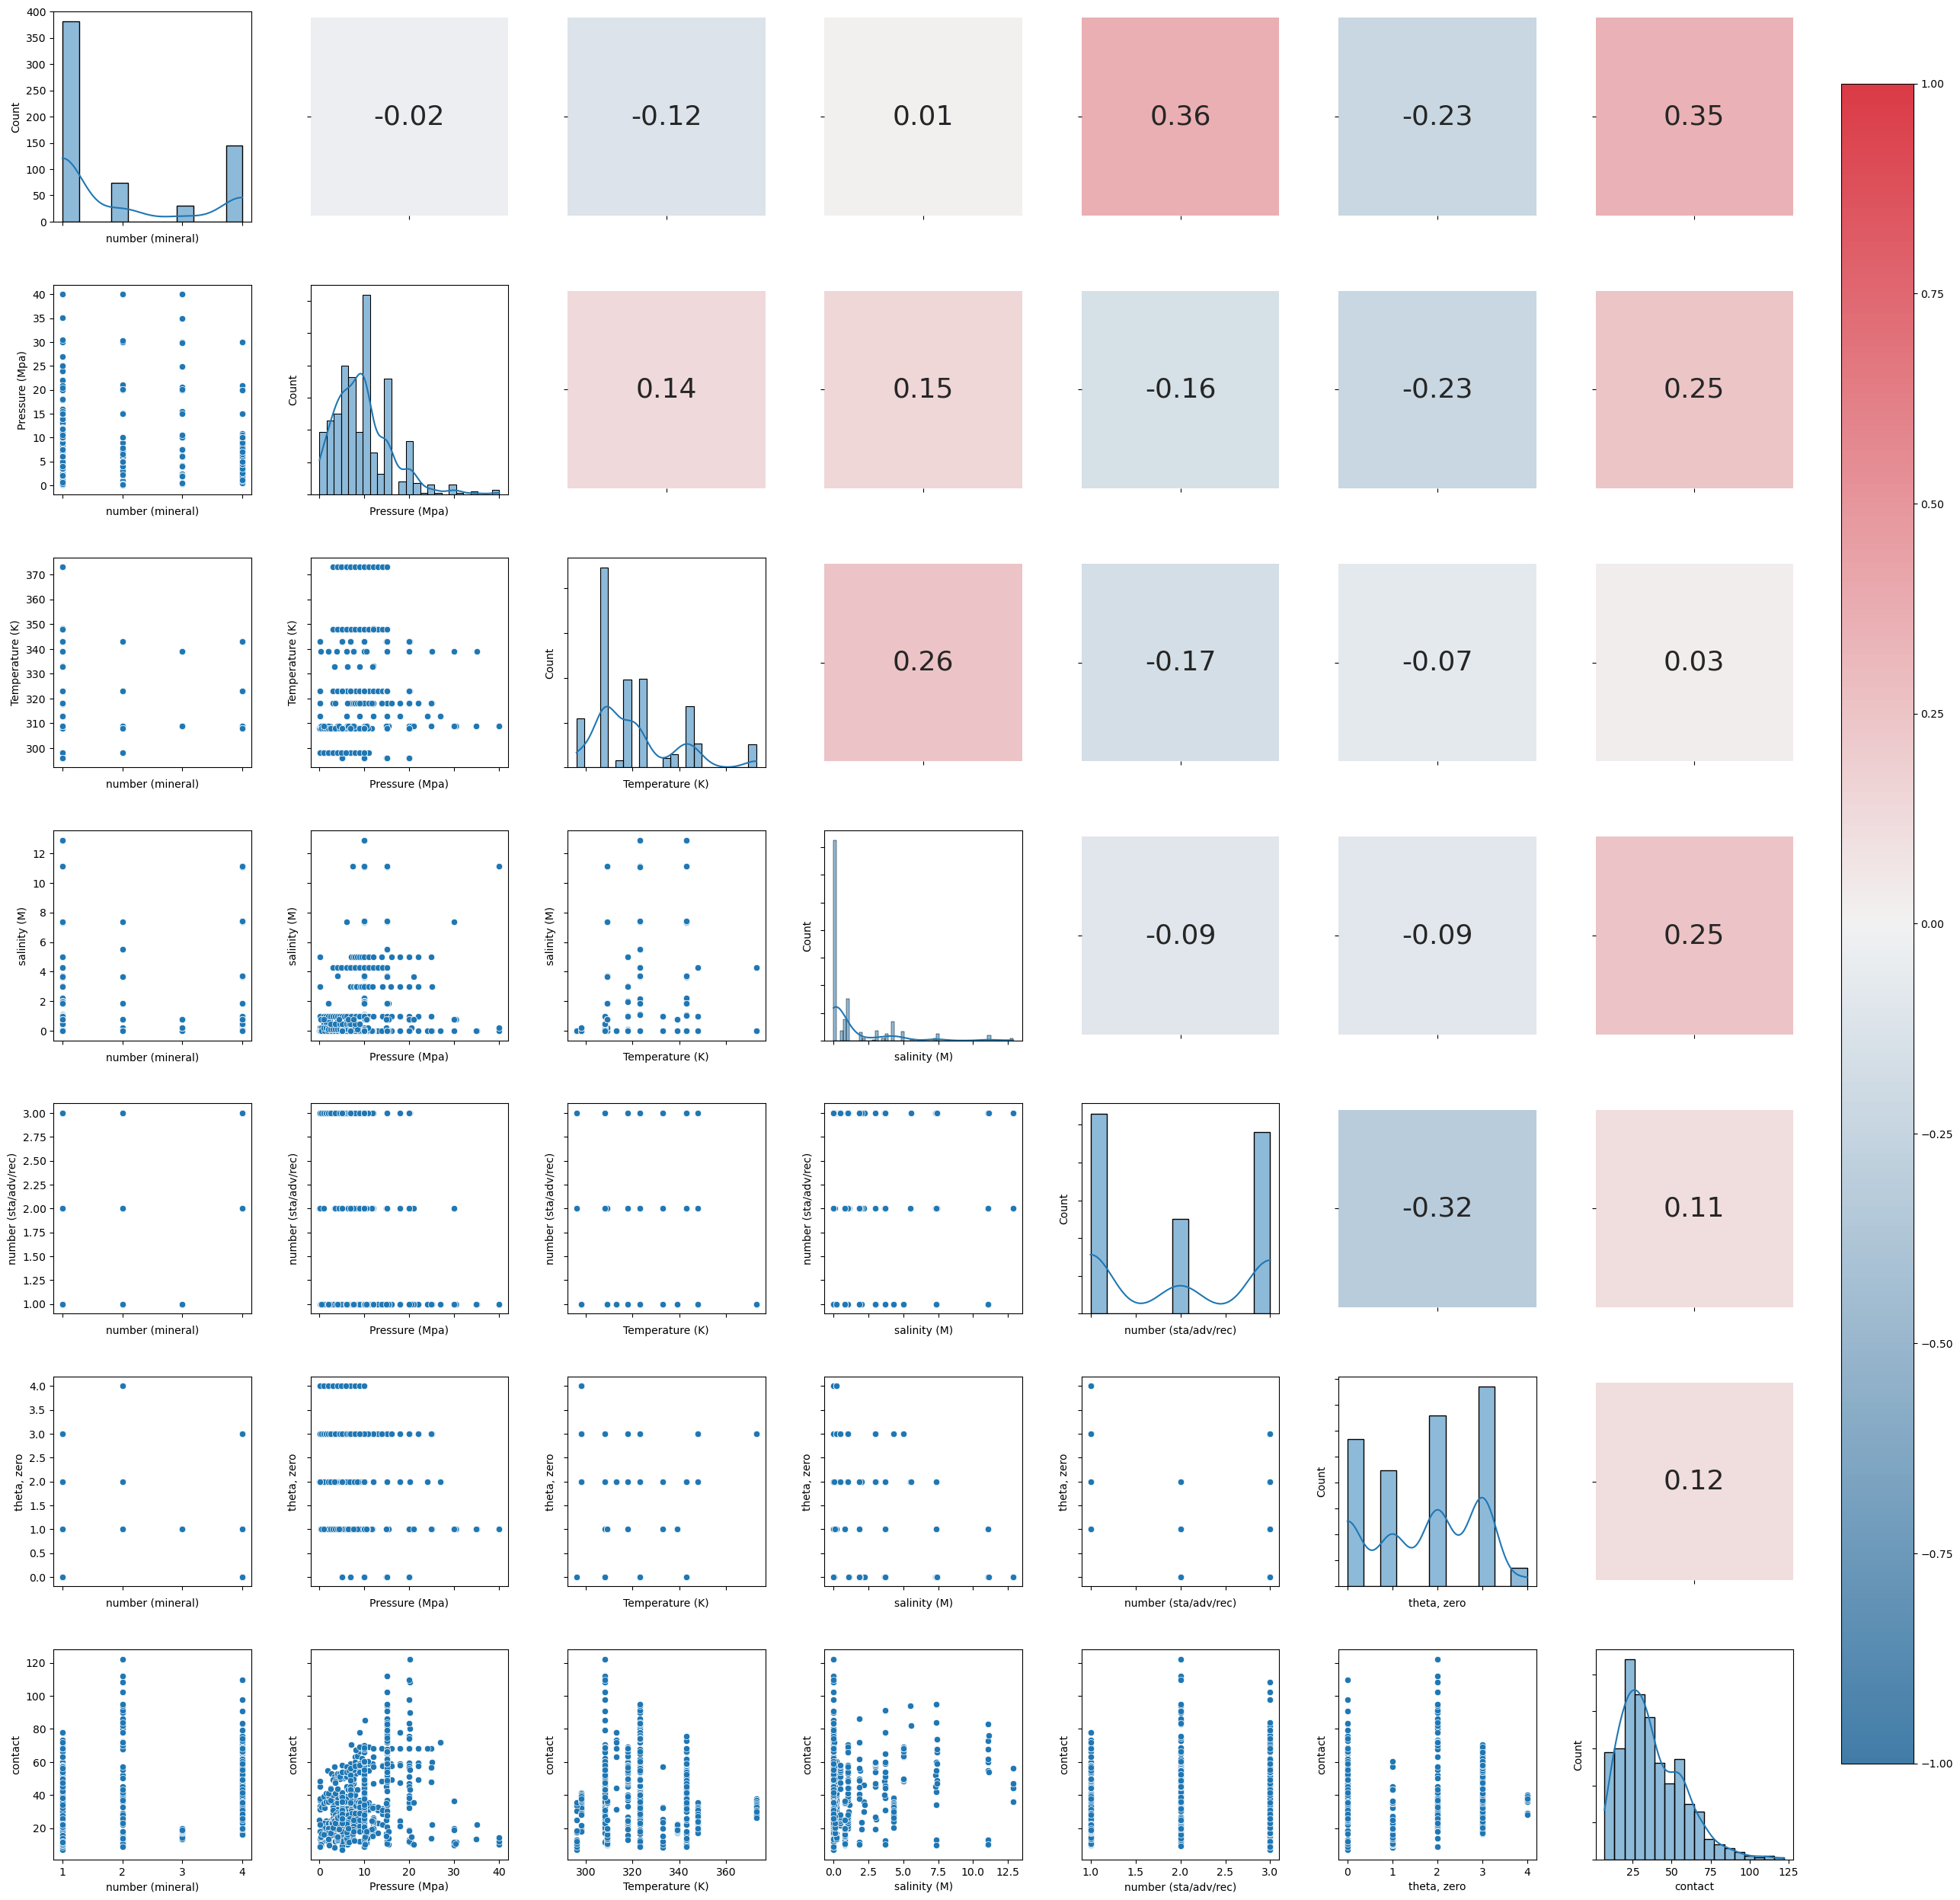

In [14]:

corr = data1.corr()
n = len(data1.columns)
fig, axes = plt.subplots(n, n, figsize=(4.5 * n, 4.5 * n))

# 绘制每个位置的散点图和直方图
for i in range(n):
    for j in range(n):
        ax = axes[i, j]
        if i == j:
            # 对角线：绘制直方图
            sns.histplot(data1.iloc[:, i], kde=True, ax=ax)
        elif i > j:
            # 下三角：绘制散点图
            sns.scatterplot(x=data1.iloc[:, j], y=data.iloc[:, i], ax=ax)
        else:
            # 上三角：绘制热图显示相关系数
            sns.heatmap(pd.DataFrame([[corr.iloc[i, j]]]), cmap=sns.diverging_palette(240, 10, as_cmap=True),
                        cbar=False, annot=True, fmt=".2f", square=True, ax=ax, vmin=-1, vmax=1,
                        annot_kws={"size": 26})  # 设置相关系数数字字体大小

        # 隐藏不需要的轴标签
        if i < n - 1:
            ax.set_xticklabels([])
        if j > 0:
            ax.set_yticklabels([])

# 调整子图之间的间距
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# 在图形旁边添加全局色条
fig.subplots_adjust(right=0.85)  # 调整图形右侧空间以显示色条
cbar_ax = fig.add_axes([0.87, 0.15, 0.03, 0.7])  # 定义色条位置和大小
norm = plt.Normalize(vmin=-1, vmax=1)
sm = plt.cm.ScalarMappable(cmap=sns.diverging_palette(240, 10, as_cmap=True), norm=norm)
sm.set_array([])  # 为空数组设置色条
fig.colorbar(sm, cax=cbar_ax)  # 添加全局色条

plt.savefig('D:\\abelly\\revision\\dataset\\input_output wettability1.png', dpi=500)
plt.show()


In [31]:
from sklearn.preprocessing import MinMaxScaler
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
data1X = scaler.fit_transform(data1.values)
data1X=pd.DataFrame(data1X,columns=data1.columns)
data1X

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,0.0,0.073732,0.025974,0.0,0.0,0.75,0.260565
1,0.0,0.098475,0.025974,0.0,0.0,0.75,0.236751
2,0.0,0.124219,0.025974,0.0,0.0,0.75,0.224801
3,0.0,0.148713,0.025974,0.0,0.0,0.75,0.243332
4,0.0,0.173457,0.025974,0.0,0.0,0.75,0.216834
...,...,...,...,...,...,...,...
625,1.0,0.123969,0.610390,0.0,1.0,0.00,0.163318
626,1.0,0.173457,0.610390,0.0,1.0,0.00,0.247662
627,1.0,0.248688,0.610390,0.0,1.0,0.00,0.300572
628,1.0,0.373407,0.610390,0.0,1.0,0.00,0.453585


In [32]:
X = data1X.drop(['contact'], axis = 1)
y= data1X['contact']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 150)

print('xtrain:',X_train.shape)
print('xtest:',X_test.shape)
print('ytrain:',y_train.shape)
print('ytest:',y_test.shape)

xtrain: (504, 6)
xtest: (126, 6)
ytrain: (504,)
ytest: (126,)


In [70]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

In [71]:
# Importing necessary librery
from sklearn import metrics
import matplotlib.pyplot as plt
#Evaluate Metrics
def evaluate_model(true, predicted):  
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    mae = metrics.mean_absolute_error(true, predicted)
    r2_square = metrics.r2_score(true, predicted)
    
    print('Mean squared error (MSE):', mse)
    print('Root mean squared error (RMSE):', rmse)
    print('Mean absolute error (MAE):', mae)
    print('R2 Square', r2_square)
    print('____________________________________')


In [ ]:
model_list=['XGBRegressor','RandomForestRegressor','SVR','MLPRegressor','KNeighborsRegressor']

param_dict={}


param_dict['SVR']={
        'kernel':[choice,0,2,['poly','rbf']],
        'C':[loguniform,-5,5],
        'gamma':[uniform,0,10]
        }
    
param_dict['MLPRegressor']={
        'hidden_layer_sizes':[choice,0,4,[(16,16),(32,16),(16,32,16),(8,8,8)]],
        'activation':[choice,0,4,['logistic', 'tanh', 'relu', 'identity']],
        'alpha':[loguniform,-5,-1],
        'learning_rate':[choice,0,2,['constant','adaptive']],
        'learning_rate_init':[loguniform,-5,-1],          
            }

param_dict['RandomForestRegressor']={
    'n_estimators':[choice,0,6,[50,100,150,300,500,1000]],
    'max_features': [choice,0,2,['sqrt','log2']],
    'max_depth': [choice,0,7,[1,3,5,10,15,20,50]]
}

param_dict['AdaBoostRegressor'] = {
    'n_estimators': [choice, 0, 5, [50, 100, 300, 500, 1000]],
    'learning_rate': [choice, 0, 5, [0.01, 0.05, 0.1, 0.5, 1.0]],
    'loss': [choice, 0, 3, ['linear', 'square', 'exponential']]
     }

param_dict['XGBRegressor']={
    'max_depth':[choice,0,5,[1,2,3,4, 5, 8, 10]],
    'subsample':[choice,0,8,[0.1,0.2,0.3,0.4,0.5,0.7, 0.8, 0.9]],
    'colsample_bytree':[choice,0,8,[0.1,0.2,0.3,0.4,0.5,0.7, 0.8, 0.9]],
    'learning_rate':[choice,0,3,[0.01, 0.1, 0.001,0.3]],
    'n_estimators':[choice,0,5,[100,300, 500, 800,1000]]
            }

param_dict['KNeighborsRegressor']={'n_neighbors':[choice,0,9,[2, 3, 4, 5,6,7,8,9,10]]}

model_dict={}

model_dict['AdaBoostRegressor']=AdaBoostRegressor
model_dict['SVR']=SVR   
model_dict['MLPRegressor']=MLPRegressor
model_dict['RandomForestRegressor']=RandomForestRegressor   
model_dict['XGBRegressor']=xgb.XGBRegressor  

In [ ]:
for model_name in model_list:       
        reg_model=model()
        reg_model.train(X_train.values,y_train.values,model_dict[model_name],param_dict[model_name])
        reg_model.optimize()
        print('model finished',reg_model)
    
        evaluate_model(y_test.values, reg_model.predict(X_test.values))

In [41]:
import joblib

In [44]:
Xgb_model=joblib.load('D:\\abelly\\revision\\model\\XGBRegressor.pkl')
RF_model =joblib.load('D:\\abelly\\revision\\model\\RandomForestRegressor.pkl')
adaboost_model= joblib.load('D:\\abelly\\revision\\model\\AdaBoostRegressor.pkl')
MLP_model =joblib.load('D:\\abelly\\revision\\model\\MLPRegressor.pkl')

RF PREDICTION

In [46]:
testPredict = RF_model.predict(X_test.values)

Predict = np.concatenate((X_test.values,testPredict.reshape(-1,1)), axis=1)
#testPredictSC = scaler.inverse_transform(Predict)

In [48]:
dataTest=pd.DataFrame(Predict,columns=data1.columns)
dataTest

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.444269
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.172868
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.220801
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.354968
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.062763
...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.450231
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.264737
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.348104
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.106626


In [49]:
testy = np.concatenate((X_test.values, y_test.values.reshape(-1,1)), axis=1)
#testYSC = scaler.inverse_transform(testY)

In [34]:
testy

array([[0.12272367, 0.24156791, 0.36      , 0.52557422, 0.        ],
       [0.02299903, 0.        , 0.3232    , 0.18416067, 0.        ],
       [1.        , 0.43755697, 0.288     , 0.24226962, 0.        ],
       ...,
       [0.06447234, 0.12215132, 0.16      , 0.59573707, 0.        ],
       [0.02069902, 0.43026436, 0.04      , 0.20066499, 0.        ],
       [0.02572438, 0.        , 0.0832    , 0.16181107, 0.        ]])

In [50]:
dataPredi=pd.DataFrame(testy,columns=data1.columns)
dataPredi

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.449602
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.183841
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.238569
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.391929
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.083045
...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.462245
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.297194
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.425875
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.087028


In [51]:
dataPredi['RF_contact']=dataTest.contact
dataPredi

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact,RF_contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.449602,0.444269
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.183841,0.172868
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.238569,0.220801
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.391929,0.354968
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.083045,0.062763
...,...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.462245,0.450231
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.297194,0.264737
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.425875,0.348104
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.087028,0.106626


XGBOSST PREDICTION

In [52]:
testPredict_XGB = Xgb_model.predict(X_test.values)

Predict = np.concatenate((X_test.values,testPredict_XGB.reshape(-1,1)), axis=1)
#testPredict_XGB = scaler.inverse_transform(Predict)
dataTest=pd.DataFrame(Predict,columns=data1.columns)
dataTest

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.459277
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.165120
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.220079
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.388676
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.043374
...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.525098
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.288125
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.365253
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.114761


In [53]:
dataPredi['XGB_contact']=dataTest.contact
dataPredi

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact,RF_contact,XGB_contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.449602,0.444269,0.459277
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.183841,0.172868,0.165120
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.238569,0.220801,0.220079
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.391929,0.354968,0.388676
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.083045,0.062763,0.043374
...,...,...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.462245,0.450231,0.525098
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.297194,0.264737,0.288125
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.425875,0.348104,0.365253
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.087028,0.106626,0.114761


ADABOOST PREDICTION

In [54]:
testPredict_adaboost = adaboost_model.predict(X_test.values)

Predict = np.concatenate((X_test.values,testPredict_XGB.reshape(-1,1)), axis=1)
#testPredict_XGB = scaler.inverse_transform(Predict)
dataTest=pd.DataFrame(Predict,columns=data1.columns)
dataTest

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.459277
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.165120
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.220079
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.388676
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.043374
...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.525098
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.288125
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.365253
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.114761


In [55]:
dataPredi['adaboost_contact']=dataTest.contact
dataPredi

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact,RF_contact,XGB_contact,adaboost_contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.449602,0.444269,0.459277,0.459277
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.183841,0.172868,0.165120,0.165120
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.238569,0.220801,0.220079,0.220079
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.391929,0.354968,0.388676,0.388676
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.083045,0.062763,0.043374,0.043374
...,...,...,...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.462245,0.450231,0.525098,0.525098
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.297194,0.264737,0.288125,0.288125
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.425875,0.348104,0.365253,0.365253
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.087028,0.106626,0.114761,0.114761


MLP PREDICTION

In [58]:
testPredict_MLP = MLP_model.predict(X_test.values)

Predict = np.concatenate((X_test.values,testPredict_XGB.reshape(-1,1)), axis=1)
dataTest=pd.DataFrame(Predict,columns=data1.columns)
dataTest

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.459277
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.165120
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.220079
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.388676
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.043374
...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.525098
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.288125
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.365253
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.114761


In [59]:
dataPredi['MLP _contact']=dataTest.contact
dataPredi

,number (mineral),Pressure,Temperature (K),salinity (M),number (sta/adv/rec),"theta, zero",contact,RF_contact,XGB_contact,adaboost_contact,MLP _contact
0,0.000000,0.233942,0.285714,0.232855,0.0,0.75,0.449602,0.444269,0.459277,0.459277,0.459277
1,0.000000,0.119470,0.155844,0.000776,1.0,0.50,0.183841,0.172868,0.165120,0.165120,0.165120
2,0.000000,0.224694,0.155844,0.007762,1.0,0.50,0.238569,0.220801,0.220079,0.220079,0.220079
3,0.000000,0.248938,0.610390,0.568306,0.5,0.00,0.391929,0.354968,0.388676,0.388676,0.388676
4,0.666667,0.009248,0.168831,0.015524,0.0,0.25,0.083045,0.062763,0.043374,0.043374,0.043374
...,...,...,...,...,...,...,...,...,...,...,...
121,1.000000,0.268683,0.155844,0.015524,1.0,0.75,0.462245,0.450231,0.525098,0.525098,0.525098
122,0.000000,0.122719,0.025974,0.015524,0.0,0.50,0.297194,0.264737,0.288125,0.288125,0.288125
123,0.000000,0.497626,0.610390,0.000000,0.5,0.00,0.425875,0.348104,0.365253,0.365253,0.365253
124,1.000000,0.061735,0.155844,0.007762,1.0,0.25,0.087028,0.106626,0.114761,0.114761,0.114761


In [61]:
excel_file_path = 'D:\\abelly\\revision\\WETTABILITY_excel_file.xlsx'
dataPredi.to_excel(excel_file_path, index=False)

Feature importance

In [64]:
# Import shap and other necessary libearies
import shap 
import graphviz
from sklearn.tree import export_graphviz
import seaborn as sns

sns.set_style('darkgrid') 

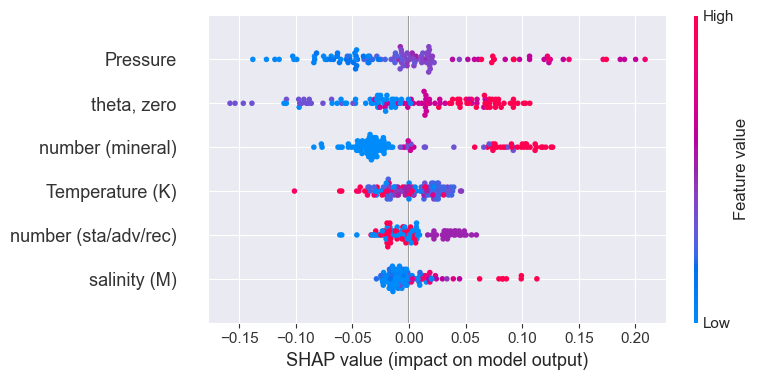

In [66]:
# Create a SHAP explainer object y_test_pred_lgbm=LGBM_model.predict(xtest)
explainer = shap.Explainer(RF_model.predict, X_test.values)

# Calculate SHAP values
shap_values = explainer(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=list(X.columns.values))

In [ ]:
plt.savefig('C:\\Users\\Lenovo\\Desktop\\sop data\\DATASET\\PEshap.jpg',dpi='auto',facecolor='auto', edgecolor='auto')